In [ ]:
pip install tensorflow


## Beijing Air Quality Forecasting

In [17]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import os




In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load training and test data
train_df = pd.read_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/test.csv')


## Explore the training data (EDA) and Preprocessing data

In [4]:

# Converting datetime to datetime object and set as index
train_df['datetime'] = pd.to_datetime(train_df['datetime'])
test_df['datetime'] = pd.to_datetime(test_df['datetime'])
train_df.set_index('datetime', inplace=True)
test_df.set_index('datetime', inplace=True)

# Handling missing values in pm2.5 (training data)
print("Before imputation, train_df shape:", train_df.shape)
train_df['pm2.5'] = train_df['pm2.5'].fillna(train_df['pm2.5'].mean())
print("After pm2.5 imputation, pm2.5 NaNs:", train_df['pm2.5'].isna().sum())
print("After imputation, train_df shape:", train_df.shape)

Before imputation, train_df shape: (30676, 11)
After pm2.5 imputation, pm2.5 NaNs: 0
After imputation, train_df shape: (30676, 11)


## Feature engineering:

In [5]:
## Adding time-based features

for df in [train_df, test_df]:
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofweek'] = df.index.dayofweek

# Adding lag features for pm2.5 (training data only)
train_df['pm2.5_lag1'] = train_df['pm2.5'].shift(1)
train_df['pm2.5_lag2'] = train_df['pm2.5'].shift(2)
train_df['pm2.5_roll_mean'] = train_df['pm2.5'].rolling(window=3).mean()

# Imputing NaNs in lag features
print("Before lag NaN imputation, train_df shape:", train_df.shape)
train_df[['pm2.5_lag1', 'pm2.5_lag2', 'pm2.5_roll_mean']] = train_df[['pm2.5_lag1', 'pm2.5_lag2', 'pm2.5_roll_mean']].fillna(train_df['pm2.5'].mean())
print("After lag NaN imputation, NaNs:", train_df[['pm2.5_lag1', 'pm2.5_lag2', 'pm2.5_roll_mean']].isna().sum())
print("After feature engineering, train_df shape:", train_df.shape)

Before lag NaN imputation, train_df shape: (30676, 19)
After lag NaN imputation, NaNs: pm2.5_lag1         0
pm2.5_lag2         0
pm2.5_roll_mean    0
dtype: int64
After feature engineering, train_df shape: (30676, 19)


In [6]:
# Defining features
base_features = ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv',
                 'hour', 'day', 'month', 'year', 'dayofweek']
features = base_features + ['pm2.5_lag1', 'pm2.5_lag2', 'pm2.5_roll_mean']
test_features = base_features
target = 'pm2.5'

In [7]:
# Scale numerical features
scaler = MinMaxScaler()
train_df[base_features] = scaler.fit_transform(train_df[base_features].astype(float))  # Ensure float type
test_df[test_features] = scaler.transform(test_df[test_features].astype(float))  # Ensure float type

In [9]:
import pandas as pd

# Load sample submission
sample_submission_path = '/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/sample.csv'
try:
    sample_submission = pd.read_csv(sample_submission_path)
    print("Sample submission shape:", sample_submission.shape)
    print("Sample row IDs head:", sample_submission['row ID'].head())
    if sample_submission.shape[0] != 13148:
        print("Warning: Sample submission does not have 13148 rows!")
except FileNotFoundError:
    print(f"Error: {sample_submission_path} not found. Please download sample_submission.csv from Kaggle and place it in the specified directory.")
    raise

Sample submission shape: (13148, 2)
Sample row IDs head: 0    2013-07-02 4:00:00
1    2013-07-02 5:00:00
2    2013-07-02 6:00:00
3    2013-07-02 7:00:00
4    2013-07-02 8:00:00
Name: row ID, dtype: object


In [11]:
import pandas as pd
import numpy as np

def add_time_features(df, date_col=None):
    df = df.copy()
    if date_col is None:
        if 'date' in df.columns:
            date_col = 'date'
        elif isinstance(df.index, pd.DatetimeIndex):
            df['date'] = df.index
            date_col = 'date'
        else:
            raise ValueError("No date column or DatetimeIndex found.")

    df[date_col] = pd.to_datetime(df[date_col])
    df['hour'] = df[date_col].dt.hour
    df['day_of_week'] = df[date_col].dt.dayofweek
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    df = df.drop(['hour', 'day_of_week'], axis=1)
    return df

def add_lag_features(df, target_col='pm2.5'):
    df = df.copy()
    df['pm2.5_lag1'] = df[target_col].shift(1)
    df['pm2.5_lag2'] = df[target_col].shift(2)
    df['pm2.5_roll_mean'] = df[target_col].rolling(window=3).mean()
    return df


# Adding date to test_df if missing
if 'date' not in test_df.columns:
    if len(sample_submission) == len(test_df):
        test_df['date'] = pd.to_datetime(sample_submission['row ID'])

    else:
        raise ValueError("sample_submission length does not match test_df.")

# Applying features
train_df = add_time_features(train_df)
train_df = add_lag_features(train_df)
train_df = train_df.dropna()

test_df = add_time_features(test_df)
if 'pm2.5' not in test_df.columns:
    test_df['pm2.5'] = np.nan
    last_train_pm25 = train_df['pm2.5'].iloc[-3:].values
    test_df.loc[:2, 'pm2.5'] = last_train_pm25
test_df = add_lag_features(test_df)
test_df = test_df.fillna(method='ffill')

# Feature lists
time_features = ['hour_sin', 'hour_cos', 'day_sin', 'day_cos']
base_features = [col for col in base_features if col in train_df.columns] + time_features
train_features = base_features + ['pm2.5_lag1', 'pm2.5_lag2', 'pm2.5_roll_mean']
test_features = base_features

def create_sequences(data, seq_length, feature_cols, target_col=None, is_test=False, target_rows=None):
    X, y = [], []
    n_features = len(feature_cols) + (3 if not is_test else 0)

    if len(data) < seq_length:
        raise ValueError(f"Data has {len(data)} rows, seq_length={seq_length}")

    if is_test and target_rows is not None:
        max_sequences = len(data) - seq_length + 1
        if max_sequences < target_rows:

         start_idx = max(0, len(data) - min(target_rows, max_sequences) - seq_length + 1)
         end_idx = len(data) - seq_length + 1
    else:
        start_idx = 0
        end_idx = len(data) - seq_length

    # Get column indices
    feature_indices = data.columns.get_indexer(feature_cols)
    if not is_test:
        lag_indices = data.columns.get_indexer(['pm2.5_lag1', 'pm2.5_lag2', 'pm2.5_roll_mean'])

    for i in range(start_idx, end_idx):
        # Extract sequence using iloc
        sequence_data = data.iloc[i:i+seq_length]
        if len(sequence_data) != seq_length:
            continue
        sequence = np.zeros((seq_length, n_features))
        try:
            # Use positional indexing for columns
            sequence[:, :len(feature_cols)] = sequence_data.iloc[:, feature_indices].values
            if not is_test:
                sequence[:, len(feature_cols):] = sequence_data.iloc[:, lag_indices].values
            X.append(sequence)
            if not is_test:
                target_idx = i + seq_length
                if target_idx < len(data):
                    y_value = data[target_col].iloc[target_idx]
                    if pd.notna(y_value):
                        y.append(y_value)
                    else:
                        X.pop()
                else:
                    X.pop()
        except Exception as e:

            continue

    X = np.array(X)
    y = np.array(y) if y else np.array([])
    if not is_test and len(X) != len(y):

        min_len = min(len(X), len(y))
        X = X[:min_len]
        y = y[:min_len]

    return X, y

seq_length = 24
target_test_rows = 13148

X_train, y_train = create_sequences(train_df, seq_length, base_features, target_col='pm2.5', is_test=False)
X_test = create_sequences(test_df, seq_length, test_features, is_test=True, target_rows=target_test_rows)[0]


<ipython-input-11-187987c2e179>:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_df = test_df.fillna(method='ffill')


## Function for plotting training history




In [12]:
# creating reusable function to plot training history
def plot_training_history(history, model_name, train_mse):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.axhline(y=train_mse, color='blue', linestyle='--', label='Final Train MSE')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.show()

## Function for saving predictions

In [13]:


# creating function to save predictions
def save_predictions(model, X, test_df, seq_length, filename, target_rows, sample_submission):

    X_test_padded = np.zeros((X.shape[0], seq_length, len(test_features) + 3))
    X_test_padded[:, :, :len(test_features)] = X
    predictions = model.predict(X_test_padded)
    predictions = np.nan_to_num(predictions)
    predictions = np.round(predictions).astype(int)

    # Get indices for predictions
    max_sequences = len(test_df) - seq_length + 1
    if max_sequences < target_rows:
        print(f"Padding: Generated {max_sequences} sequences, need {target_rows}")

    # Get row IDs from sample_submission for the predictions
    pred_indices = test_df.index[-(X.shape[0]):]
    # Map indices to sample_submission row IDs
    pred_row_ids = sample_submission['row ID'].iloc[pred_indices]

    # Create initial submission
    submission = pd.DataFrame({
        'row ID': pred_row_ids,
        'pm2.5': predictions.flatten()
    })

    # Pad with mean pm2.5 if needed
    if submission.shape[0] != target_rows:
        missing_rows = target_rows - submission.shape[0]
        print(f"Padding {missing_rows} rows with mean pm2.5")
        mean_pm25 = int(round(train_df['pm2.5'].mean()))

        # Get expected row IDs from sample_submission
        sample_row_ids = sample_submission['row ID'].tolist()
        submission_row_ids = submission['row ID'].tolist()
        missing_ids = [rid for rid in sample_row_ids if rid not in submission_row_ids][:missing_rows]

        if len(missing_ids) < missing_rows:
            print("Warning: Not enough unique row IDs in sample_submission. Using last timestamp.")
            last_timestamp = pd.to_datetime(test_df['date']).iloc[-1] if 'date' in test_df.columns else pd.to_datetime(sample_submission['row ID'].iloc[-1])
            missing_ids = pd.date_range(
                last_timestamp + pd.Timedelta(hours=1),
                periods=missing_rows,
                freq='H'
            ).strftime('%Y-%m-%d %H:%M:%S').tolist()

        missing_df = pd.DataFrame({
            'row ID': missing_ids,
            'pm2.5': [mean_pm25] * missing_rows
        })
        submission = pd.concat([submission, missing_df], ignore_index=True)


    if submission.shape[0] != target_rows:
        raise ValueError(f"Submission has {submission.shape[0]} rows, expected {target_rows}")

    # Sort and save
    submission = submission.sort_values(by='row ID')
    submission.to_csv(f'/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/{filename}', index=False)

Training Baseline Model...
X_train shape before fit: (30652, 24, 17)
y_train shape before fit: (30652,)
Epoch 1/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 31s 35ms/step - loss: 7474.1685 - val_loss: 1749.4056
Epoch 2/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - loss: 1087.1189 - val_loss: 1308.9684
Epoch 3/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 40s 33ms/step - loss: 967.0270 - val_loss: 1299.2146
Epoch 4/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 25s 33ms/step - loss: 908.0124 - val_loss: 1204.9987
Epoch 5/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - loss: 967.5923 - val_loss: 1269.3489
Epoch 6/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - loss: 876.0607 - val_loss: 1238.7595
Epoch 7/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 42s 32ms/step - loss: 905.2409 - val_loss: 1126.7161
Epoch 8/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 27s 36ms/step - loss: 933.3601 - val_loss: 1243.7412
Epoch 9/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 39s 33ms/step - loss: 824.0711 - val_loss: 1090.8396
Epoch 10/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 25s 33ms/step - 

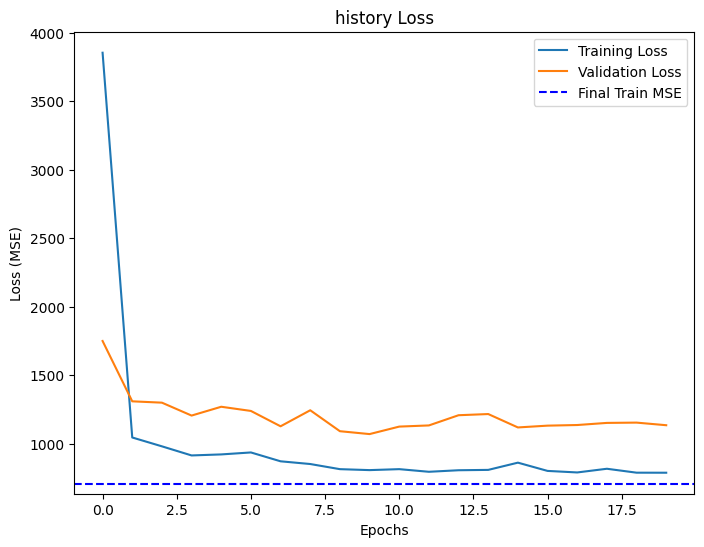

test_df index type: <class 'pandas.core.indexes.range.RangeIndex'>
test_df index head: RangeIndex(start=0, stop=5, step=1)
test_df columns: Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv'],
      dtype='object')
sample_submission row IDs head: 0    2013-07-02 4:00:00
1    2013-07-02 5:00:00
2    2013-07-02 6:00:00
3    2013-07-02 7:00:00
4    2013-07-02 8:00:00
Name: row ID, dtype: object
411/411 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
Padding: Generated 13125 sequences, need 13148
Padding 23 rows with mean pm2.5
Submission shape for prediction5.csv: (13148, 2)


In [ ]:

from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def train_baseline_model():
    model = Sequential([
        Input(shape=(seq_length, len(base_features) + 3)),
        LSTM(64, return_sequences=True),
        Dropout(0.2),
        LSTM(64),
        Dropout(0.2),
        Dense(50, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
    print("X_train shape before fit:", X_train.shape)
    print("y_train shape before fit:", y_train.shape)
    history = model.fit(
        X_train,
        y_train,
        epochs=20,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=1
    )
    train_predictions = model.predict(X_train)
    train_mse = np.mean((y_train - train_predictions.flatten())**2)
    train_rmse = np.sqrt(train_mse)
    print(f"Training RMSE: {train_rmse}")
    plot_training_history(history, 'history', train_mse)
    save_predictions(
        model,
        X_test,
        test_df,
        seq_length,
        'prediction5.csv',
        target_rows=target_test_rows,
        sample_submission=sample_submission
    )
    return model, history

print("Training Baseline Model...")
model_baseline, history_baseline = train_baseline_model()


Training CNN-LSTM Hybrid Model...
X_train shape before fit: (30652, 24, 17)
y_train shape: (30652,)
Epoch 1/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 29s 51ms/step - loss: 11629.8174 - val_loss: 4409.0483
Epoch 2/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - loss: 2174.4922 - val_loss: 2041.6245
Epoch 3/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 22s 51ms/step - loss: 1287.3369 - val_loss: 1486.3901
Epoch 4/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - loss: 1263.9204 - val_loss: 2695.3438
Epoch 5/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 22s 51ms/step - loss: 1124.1765 - val_loss: 1692.4994
Epoch 6/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - loss: 1104.8516 - val_loss: 1785.1437
Epoch 7/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - loss: 1042.4933 - val_loss: 3668.2080
Epoch 8/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 25s 59ms/step - loss: 999.8297 - val_loss: 3484.3728
Epoch 9/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 38s 51ms/step - loss: 955.1340 - val_loss: 1921.8972
Epoch 10/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step

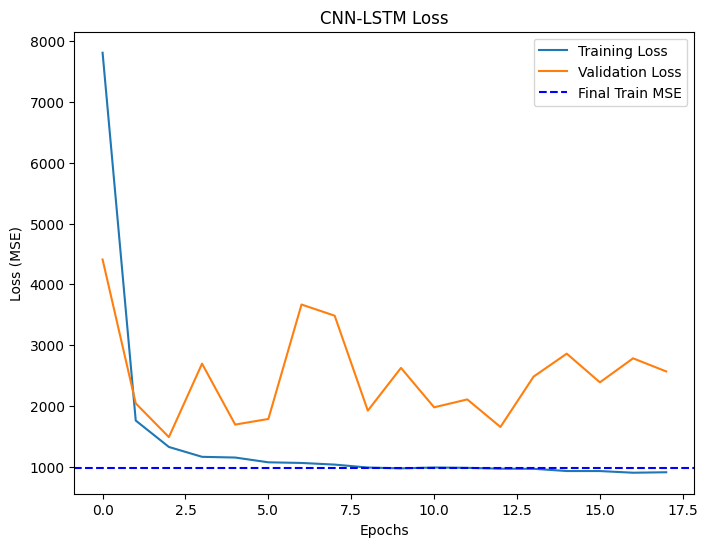

test_df index type: <class 'pandas.core.indexes.range.RangeIndex'>
test_df index head: RangeIndex(start=0, stop=5, step=1)
test_df columns: Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv'],
      dtype='object')
sample_submission row IDs head: 0    2013-07-02 4:00:00
1    2013-07-02 5:00:00
2    2013-07-02 6:00:00
3    2013-07-02 7:00:00
4    2013-07-02 8:00:00
Name: row ID, dtype: object
411/411 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step
Padding: Generated 13125 sequences, need 13148
Padding 23 rows with mean pm2.5
Submission shape for prediction7.csv: (13148, 2)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd

# Ensuring target_test_rows and sample_submission are defined
if 'target_test_rows' not in globals():
    target_test_rows = 13148
    print("Defined target_test_rows:", target_test_rows)
if 'sample_submission' not in globals():
    sample_submission_path = '/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/sample_submission.csv'
    try:
        sample_submission = pd.read_csv(sample_submission_path)
        print("Loaded sample_submission shape:", sample_submission.shape)
    except FileNotFoundError:
        raise FileNotFoundError(f"{sample_submission_path} not found.")

def train_cnn_lstm_model():
    model = Sequential([
        Input(shape=(seq_length, len(base_features) + 3)),
        Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
        Dropout(0.3),
        Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
        Dropout(0.3),
        LSTM(50, return_sequences=True),
        Dropout(0.3),
        LSTM(50),
        Dropout(0.3),
        Dense(50, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
    print("X_train shape before fit:", X_train.shape)
    print("y_train shape:", y_train.shape)
    history = model.fit(
        X_train, y_train,
        epochs=20,
        batch_size=64,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=1
    )
    train_predictions = model.predict(X_train, verbose=0)
    train_mse = np.mean((y_train - train_predictions.flatten())**2)
    train_rmse = np.sqrt(train_mse)
    print(f"CNN-LSTM - Training RMSE: {train_rmse}")
    # Pass history, not history.history
    try:
        plot_training_history(history, 'CNN-LSTM', train_mse)
    except Exception as e:
        print(f"Error in plot_training_history: {e}")
    save_predictions(
        model, X_test, test_df, seq_length, 'prediction7.csv',
        target_rows=target_test_rows, sample_submission=sample_submission
    )
    return model, history

print("\nTraining CNN-LSTM Hybrid Model...")
model_cnn_lstm, history_cnn_lstm = train_cnn_lstm_model()


Training Deeper LSTM Model...
X_train shape before fit: (30648, 24, 20)
y_train shape: (30648,)
Epoch 1/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 97s 119ms/step - loss: 7592.4390 - val_loss: 1776.9224
Epoch 2/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 97s 126ms/step - loss: 1172.5376 - val_loss: 1478.8608
Epoch 3/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 133s 114ms/step - loss: 1223.1394 - val_loss: 1240.5079
Epoch 4/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 154s 130ms/step - loss: 992.8746 - val_loss: 1916.8988
Epoch 5/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 93s 122ms/step - loss: 989.6987 - val_loss: 1148.0350
Epoch 6/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 133s 110ms/step - loss: 944.6243 - val_loss: 1105.5288
Epoch 7/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 143s 113ms/step - loss: 912.9341 - val_loss: 1177.1423
Epoch 8/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 141s 111ms/step - loss: 868.4901 - val_loss: 1161.5067
Epoch 9/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 144s 114ms/step - loss: 994.7520 - val_loss: 1086.6923
Epoch 10/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 140s 11

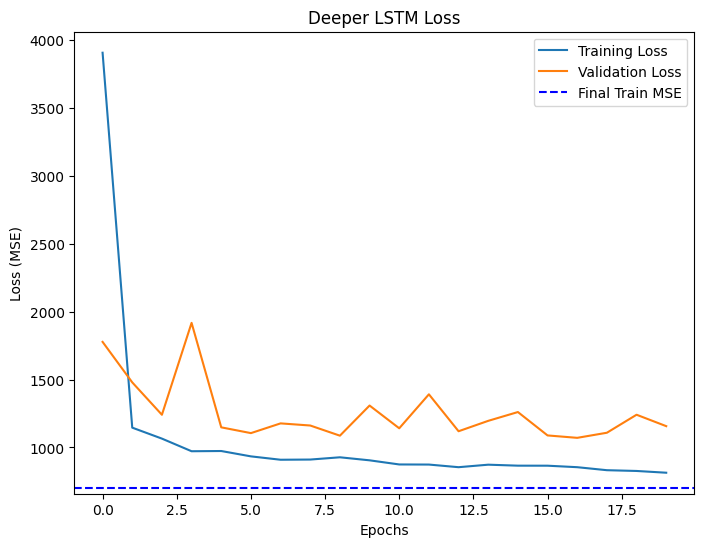

In [16]:
## Deeper LSTM Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def train_deeper_lstm_model():
    model = Sequential([
        Input(shape=(seq_length, len(base_features) + 3)),
        LSTM(128, return_sequences=True),
        Dropout(0.3),
        LSTM(128, return_sequences=True),
        Dropout(0.3),
        LSTM(64),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
    print("X_train shape before fit:", X_train.shape)
    print("y_train shape:", y_train.shape)
    history = model.fit(
        X_train, y_train,
        epochs=20,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=1
    )
    train_predictions = model.predict(X_train, verbose=0)
    train_mse = np.mean((y_train - train_predictions.flatten())**2)
    train_rmse = np.sqrt(train_mse)
    print(f"Deeper LSTM - Training RMSE: {train_rmse}")
    plot_training_history(history, 'Deeper LSTM', train_mse)

    return model, history

print("\nTraining Deeper LSTM Model...")
model_deeper_lstm, history_deeper_lstm = train_deeper_lstm_model()